# Scikit-Reduced Model Tutorial

In [ ]:
import old_code.hpg_norm as hpg_norm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import arby

#autoreload permite que jupyter vea las modif de los script de forma automática
%load_ext autoreload
%autoreload 2

In [4]:
path = "tests/waveforms/"
q_train = np.load(path+"q_train_1d-seed_eq_1.npy")
q_test = np.load(path+"q_test_1d-seed_eq_1.npy")
ts_train = np.load(path+"ts_train_1d-seed_eq_1.npy")
ts_test = np.load(path+"ts_test_1d-seed_eq_1.npy")
times = np.load(path+"times_1d-seed_eq_1.npy")
"""
for idx in [1,-1]:
    print(q_train[idx])
    q_train[idx]
    plt.plot(times,np.imag(ts_train[idx]))
    plt.plot(times,np.real(ts_train[idx]));
"""

'\nfor idx in [1,-1]:\n    print(q_train[idx])\n    q_train[idx]\n    plt.plot(times,np.imag(ts_train[idx]))\n    plt.plot(times,np.real(ts_train[idx]));\n'

In [5]:
from anytree import RenderTree
def visual_tree(tree):
    for pre, fill, node in RenderTree(tree):
        print("%s%s" % (pre, node.name))

In [6]:
%%time
from skreducedmodel.reducedbasis import ReducedBasis

rb = ReducedBasis(index_seed_global_rb = 0,
                  greedy_tol = 1e-16,
                  lmax = 2,
                  nmax = 5,
                  normalize = True,
                  integration_rule="riemann"
                  )

rb.fit(training_set = ts_train, 
       parameters = q_train, 
       physical_points = times
       )

# visual_tree(rb.tree)

CPU times: user 4.7 s, sys: 4.63 s, total: 9.33 s
Wall time: 1.43 s


In [7]:
from skreducedmodel.reducedbasis import normalize_set, error
ts_test_normalized = normalize_set(ts_test, times)

In [8]:
hts = []
for h,q in zip(ts_test_normalized,q_test):
    hts.append(rb.transform(h,q))
hts = np.array(hts)

In [10]:
errors1 = []
for i in range(100):
    errors1.append(error(ts_test_normalized[i],hts[i],times))

-----

In [9]:
%%time
N_max = 5
L_max = 2
tree_old_code = hpg_norm.hpgreedy(ts_train, q_train, times, N_max = N_max, L_max = L_max, normalize = True, greedy_tol = 1e-16)

CPU times: user 20 s, sys: 33.4 s, total: 53.5 s
Wall time: 7.25 s


In [10]:
#normalized_ts_test = normalize_set(ts_test,times)
errors = []
for q, wf in zip(q_test, ts_test_normalized):
    error = np.real(hpg_norm.proj_error_hpgreedy(tree_old_code, q, wf))
    errors.append(error)

/home/fcerino/env_skrm/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


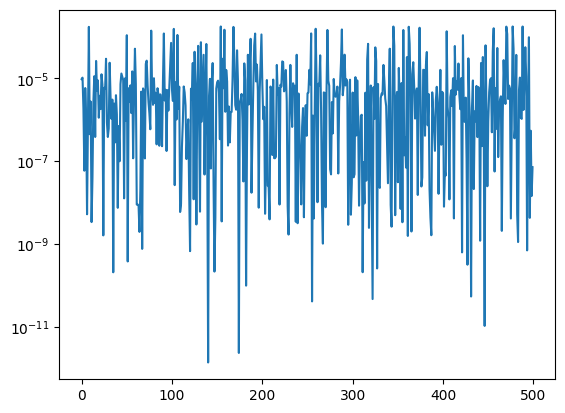

In [11]:
plt.yscale("log")
plt.plot(errors1,label="skrm")

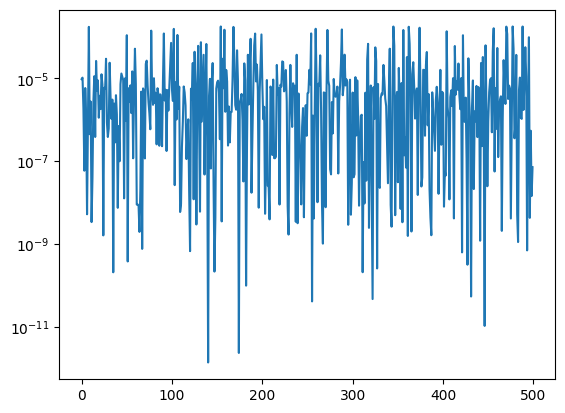

In [12]:
plt.yscale("log")
plt.plot(errors)

--------

In [15]:
%%time
arby_model = arby.reduced_basis(ts_train, times, greedy_tol=1e-16, normalize=True)

arby_model.errors,len(arby_model.errors)

CPU times: user 5.18 s, sys: 9.2 s, total: 14.4 s
Wall time: 2.44 s


(array([9.71144462e-01, 9.29887628e-01, 8.87487769e-01, 8.73268169e-01,
        8.47193863e-01, 8.20994075e-01, 1.27733997e-01, 1.40122878e-02,
        1.00016899e-03, 6.64974391e-05, 3.50646811e-06, 1.96794909e-07,
        5.29893677e-08, 5.98261286e-09, 1.60607225e-10, 1.68101223e-11,
        3.63052245e-12, 1.89960641e-13, 2.25019005e-14, 8.82930962e-15,
        8.61493152e-15]),
 21)

In [16]:
import old_code.hpg_norm as hpg_norm

N_max = 25
L_max = 2
greedy_tol = 1e-16
tree = hpg_norm.hpgreedy(ts_train,q_train, times,
                         greedy_tol, N_max, L_max,
                         normalize = True)

for leaf in tree.leaves:
    print(leaf.rb_parameters_idxs)

[0, 69, 35, 19, 63, 23, 7, 15, 13, 48, 78]
[0, 13, 117, 62, 56, 82, 83, 115, 88, 71, 52]
[0, 42, 1, 84, 83, 58, 153, 121, 154, 75, 155]
[0, 18, 65, 34, 91, 48, 58, 69, 63, 49, 45]


In [17]:
len(tree.leaves)

4

In [18]:
arby_model.indices

[0,
 66,
 357,
 251,
 107,
 1,
 109,
 281,
 459,
 332,
 157,
 327,
 313,
 258,
 412,
 396,
 63,
 72,
 493,
 415,
 499]

In [39]:
arby_model.errors==rb.errors

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [40]:
projected_f = arby_model.basis.project(ts_test[0])

In [84]:
def normalize_set(array,domain,rule = "riemann"):
    integration = arby.integrals.Integration(domain, rule)
    norms = integration.norm(array)
    return np.array(
            [
                h if np.allclose(h, 0, atol=1e-15) else h / norms[i]
                for i, h in enumerate(array)
            ]
        )

#normalize with arby code
normalized_ts_train = normalize_set(ts_train,times)
#del ts_train
normalized_ts_test = normalize_set(ts_test,times)
#del ts_test

print(times.shape)
print(q_train.shape,normalized_ts_train.shape)
print(q_test.shape,normalized_ts_test.shape)

(31300,)
(500, 3) (500, 31300)
(500, 3) (500, 31300)


In [17]:
greedy_tol = 1e-16
normalize = True
model = Surrogate()

results = {}
for lmax in range(0,1):
    for nmax in [20,np.inf]:
        
        model.fit(ts_train, q_train, times, greedy_tol, nmax, lmax, normalize)
        
        errors = []
        for q, wf in zip(q_test, ts_test):
            error = np.real(hpg_norm.proj_error_hpgreedy(tree, q, wf/hpg_norm.norm_riemann(wf,dt=0.1), N))
            errors.append(error)

        results[(L_max,N_max)] = {}
        results[(L_max,N_max)]["max_errors"] = np.max(errors)
        results[(L_max,N_max)]["mean_errors"] = np.mean(errors)
        print(f"N_max = {N_max}, L_max = {L_max}. max error = {max_errors[-1]}")

NameError: name 'hpg_norm' is not defined